In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Define the fitting models

In [2]:
# Define a general hyperbolic tangent model
def area_tanh(t, a, b, c, d):
    """
    t: time
    a,b,c,d: constants to be fitted
    """
    return a*np.tanh(b*(t-c))+d

def der_area_tanh(t, a, b, c, ):
    """
    t: time
    a,b,c,d: constants to be fitted
    """
    return a*b*(1-(np.tanh(b*(t-c)))**2)

# Define the logistic growth rate model
def area_logistic(t, a0, r, k):
    """
    t  :time
    a0 : area at time zer0
    r  : growth rate
    k  : carrying capacity
    """
    c = k/a0 - 1
    return k / (1 + c*np.exp(-r*t))

def der_area_logistic(t, a0, r, k):
    """
    t  :time
    a0 : area at time zer0
    r  : growth rate
    k  : carrying capacity
    """
    c = k/a0 - 1
    rkc = r*k*c
    return rkc*np.exp(-r*t) / (1 + c*np.exp(-r*t))**2

### Read the data frame and show a summary of the growth curves and the fitting models

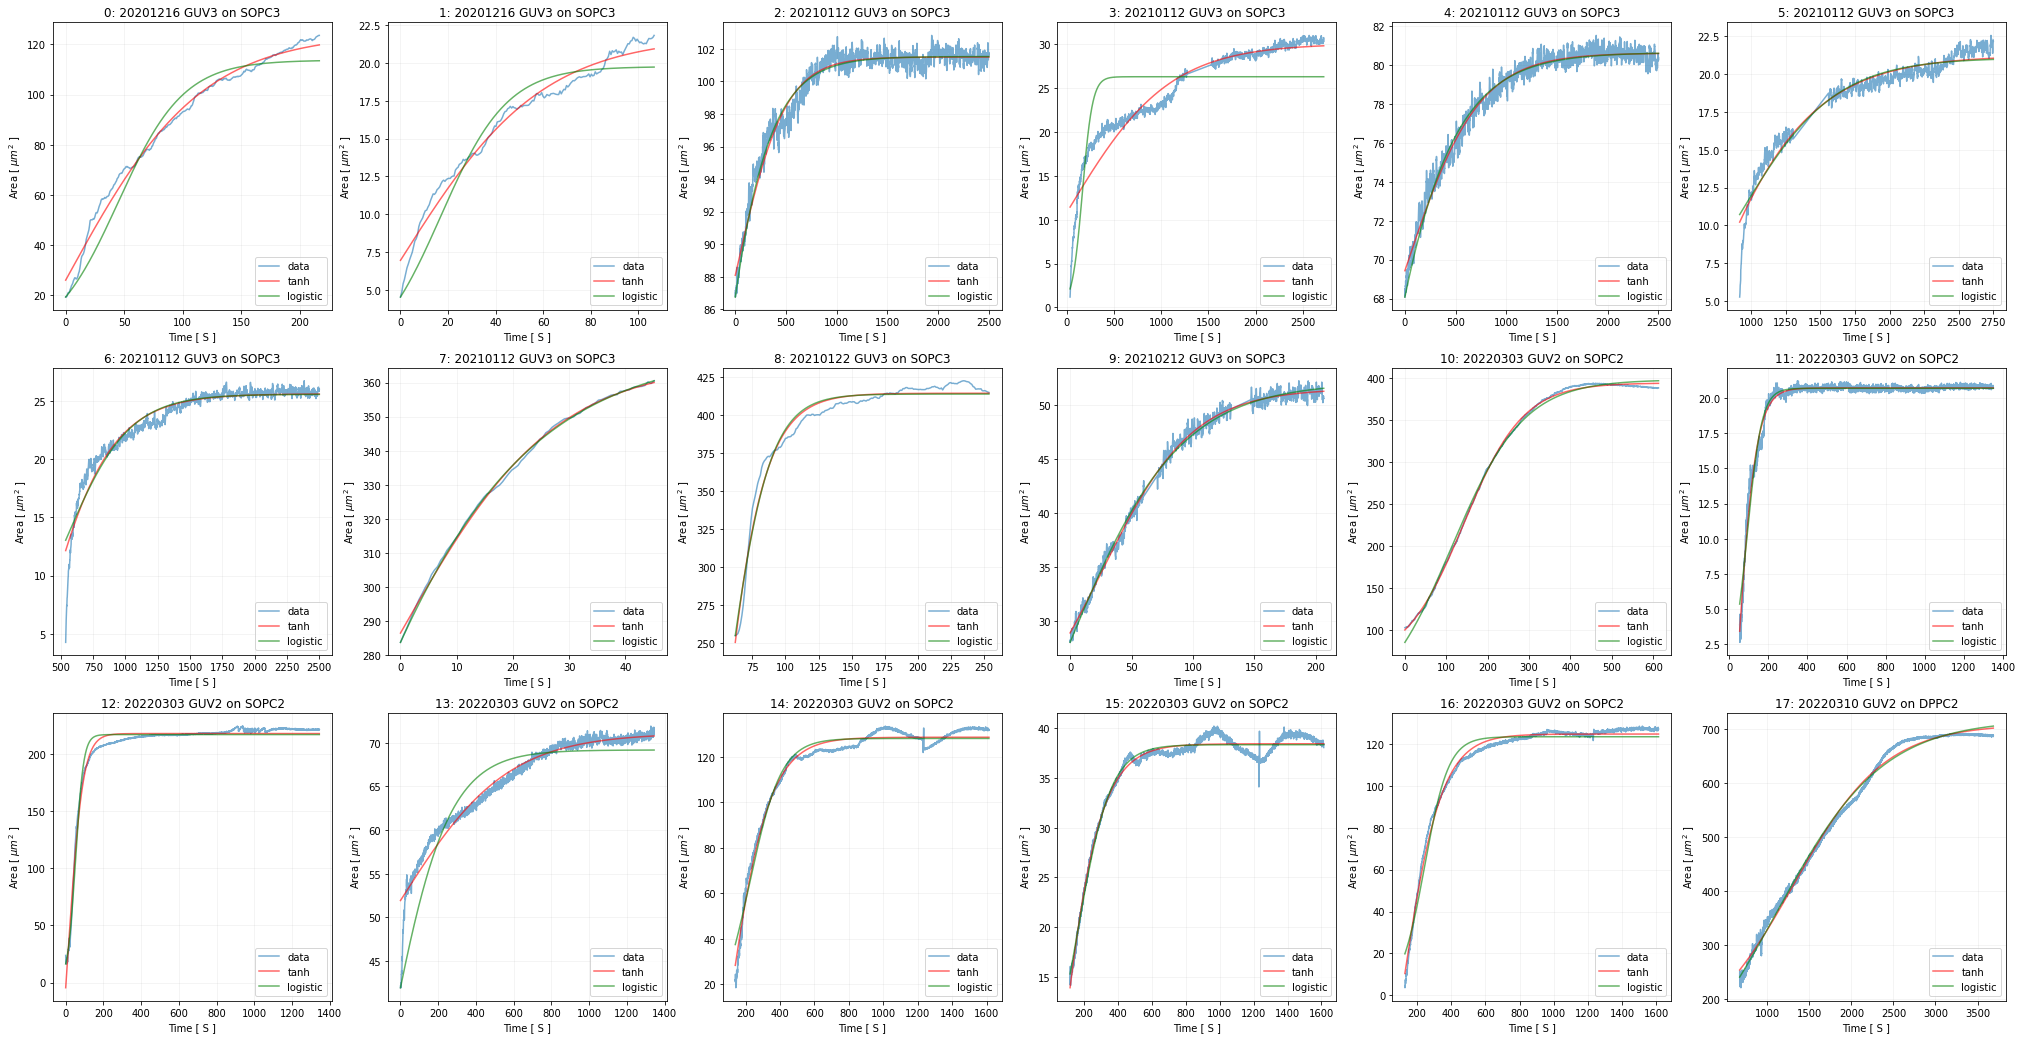

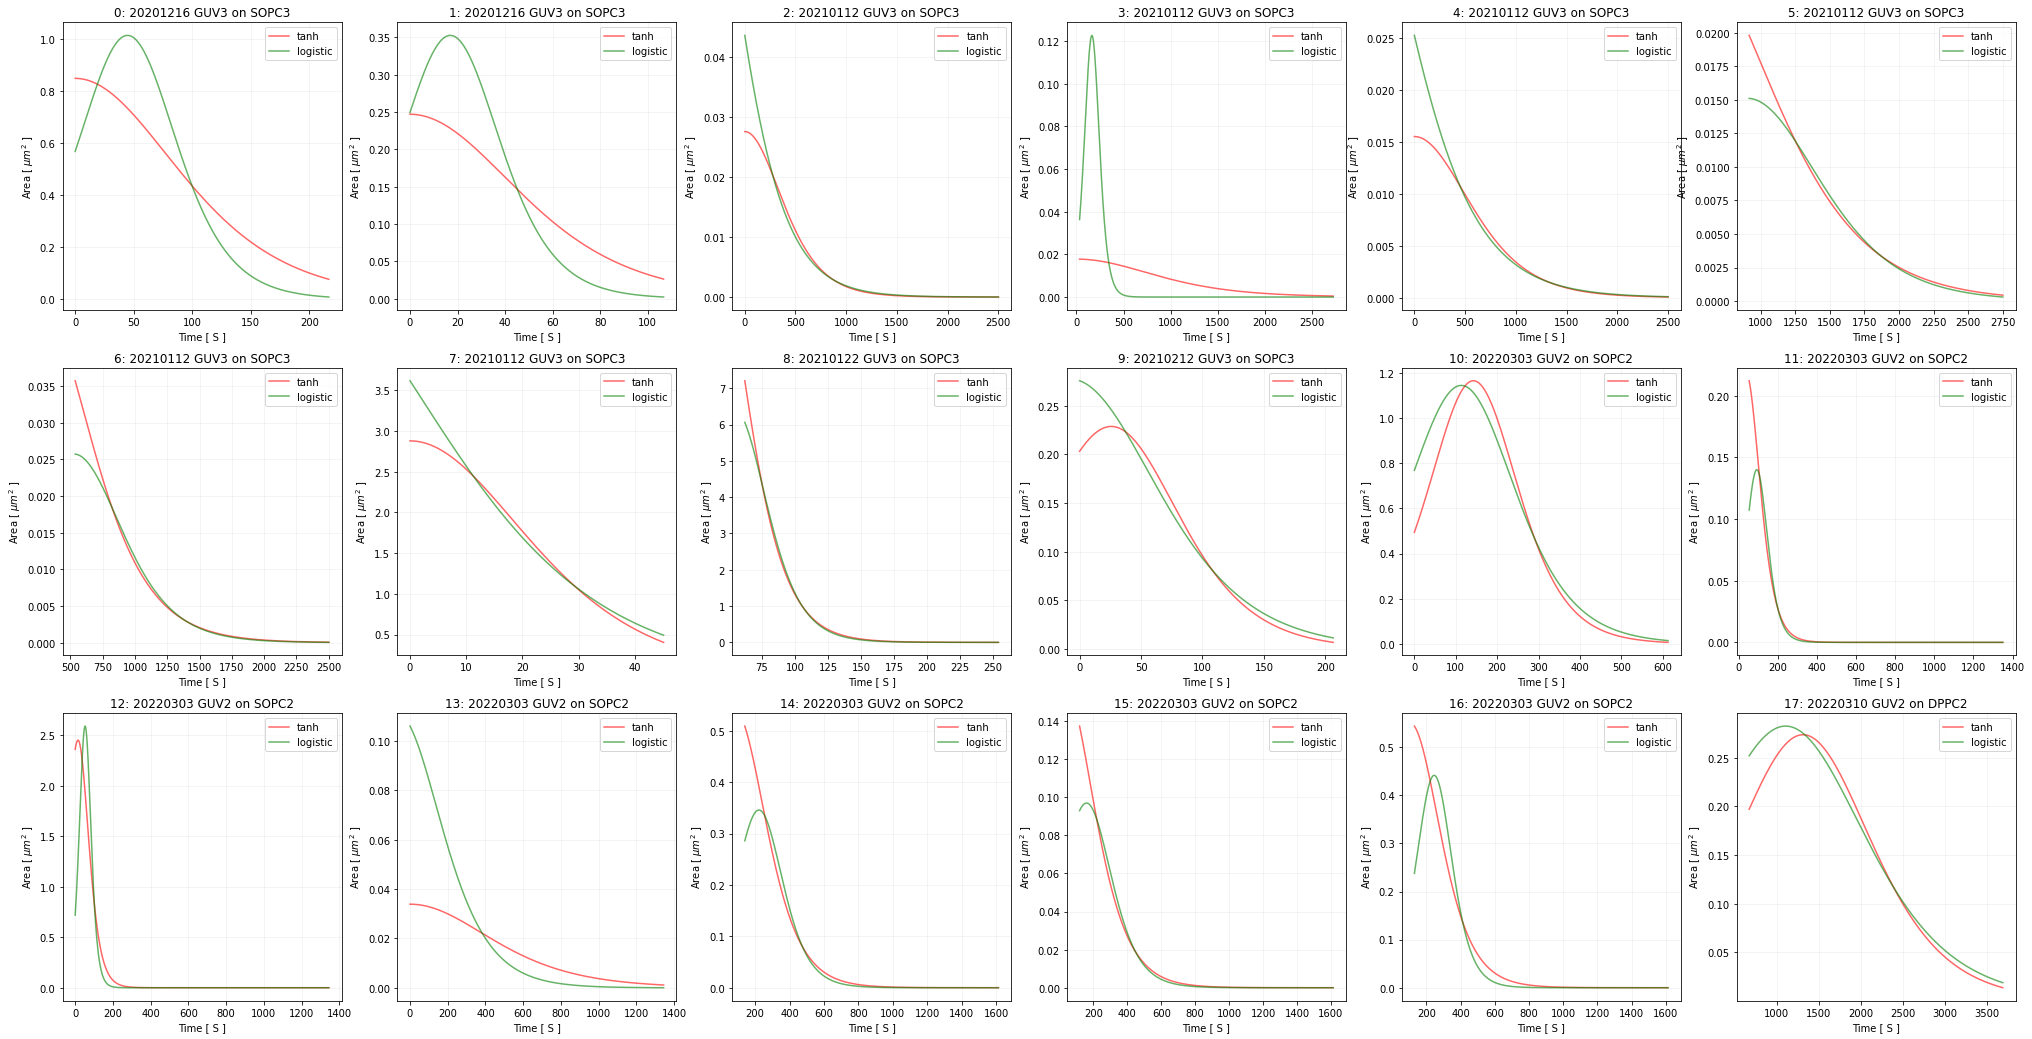

In [3]:
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

parameters_tanh, parameters_logistic = [], []
for i in range(18):
    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]
    
    # Fit a general tanh function to the curves 
    popt_tanh, _ = curve_fit(area_tanh, t, A,
                             p0=(np.max(A)-np.min(A), 0.01, 0, 0),
                             bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], 1.5*np.max(A)]))
    parameters_tanh.append(popt_tanh)
                   
    # Fit a general tanh function to the curves 
    popt_logistic, _ = curve_fit(area_logistic, t, A,
                                 p0=(1, 0.01, np.max(A)),
                                 bounds=([0.1, 0.00001, np.min(A)], [np.min(A), 1, 2*np.max(A)]))
    parameters_logistic.append(popt_logistic)
    
    # Define the figure size only once
    if i==0: plt.figure(figsize=(35, 18))
    
    plt.subplot(3, 6, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
    plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')
    
plt.savefig('Results/area_curves_2')
plt.show()


# Draw the derivative curves
for i in range(18):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.figure(figsize=(35, 18))
    
    plt.subplot(3, 6, i+1)
    plt.plot(t, der_area_tanh(t, *parameters_tanh[i][:-1]), label='tanh', alpha = 0.6, color= 'r')           # tanh
    plt.plot(t, der_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_2_der')
plt.show()

### Decrease the sigmas on the begining and ending of the curve

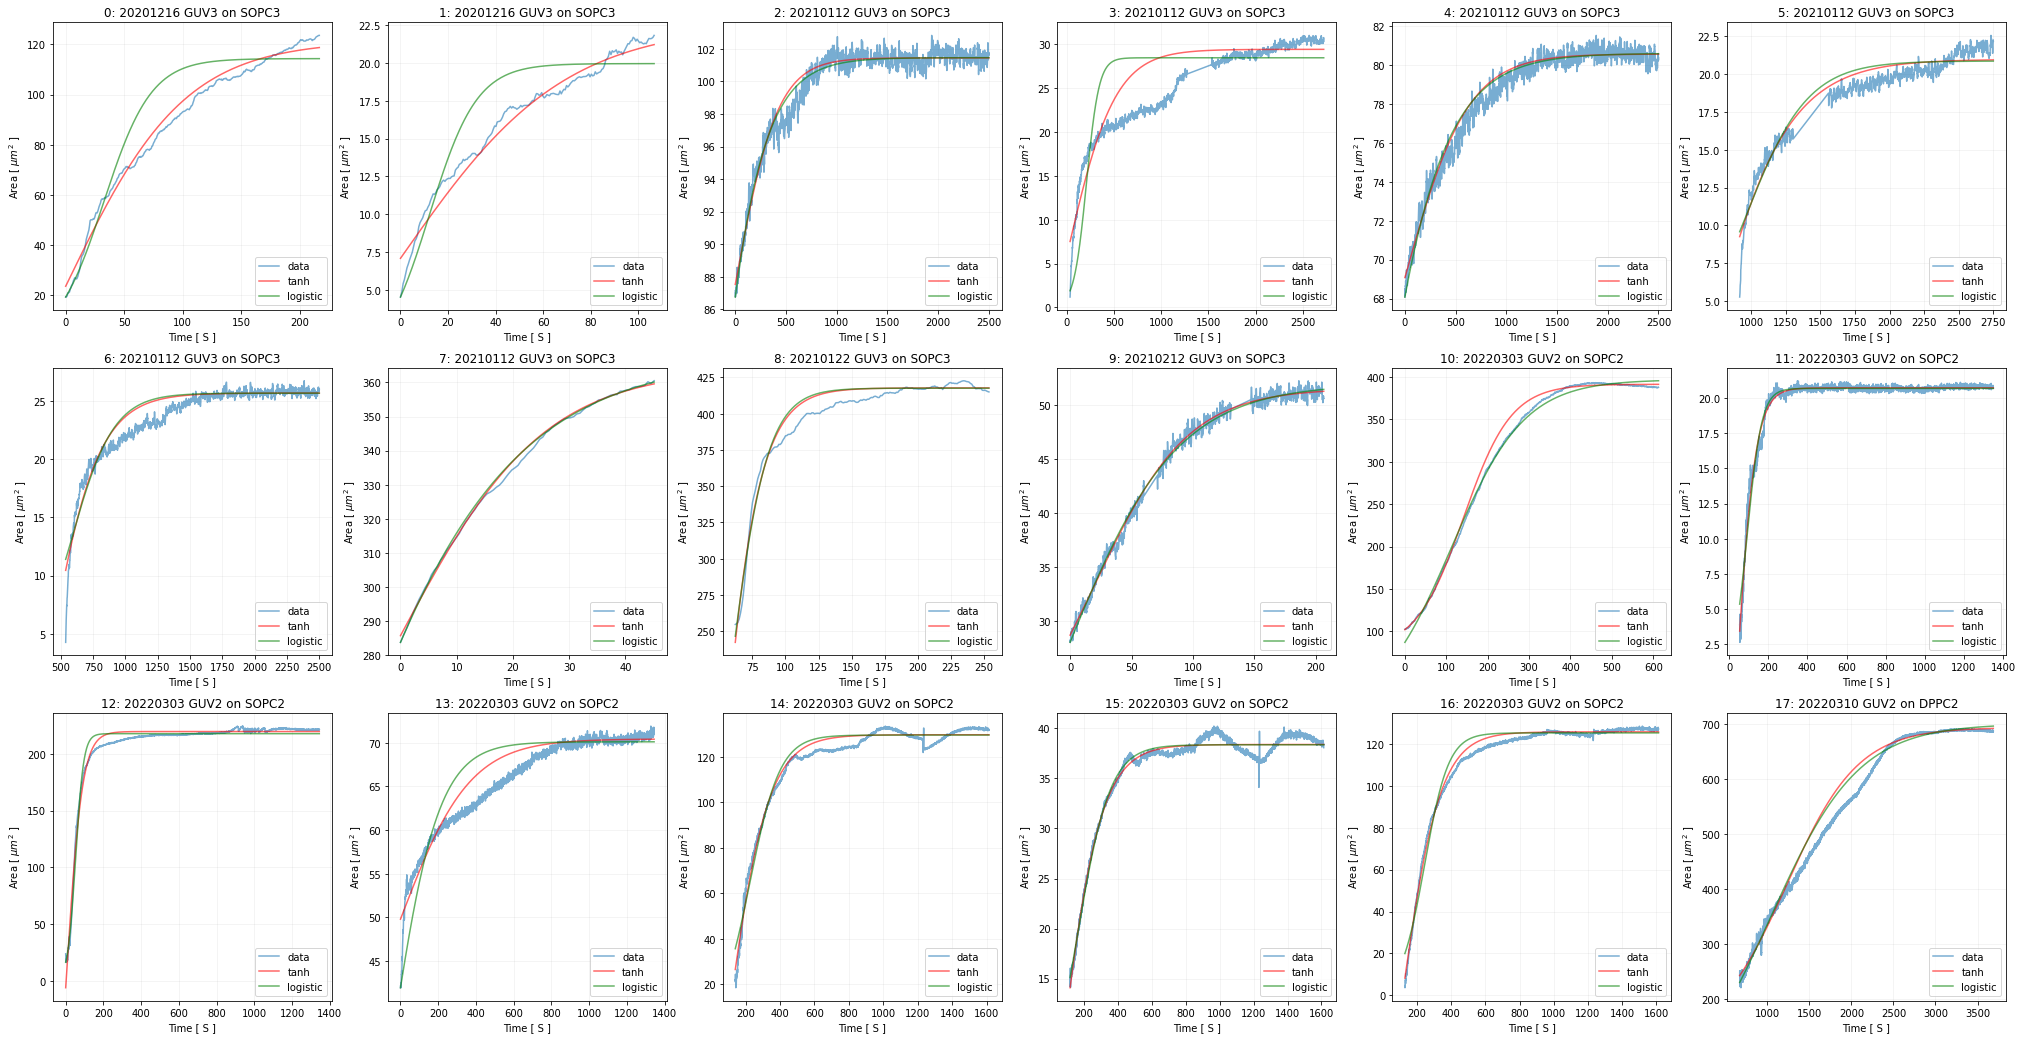

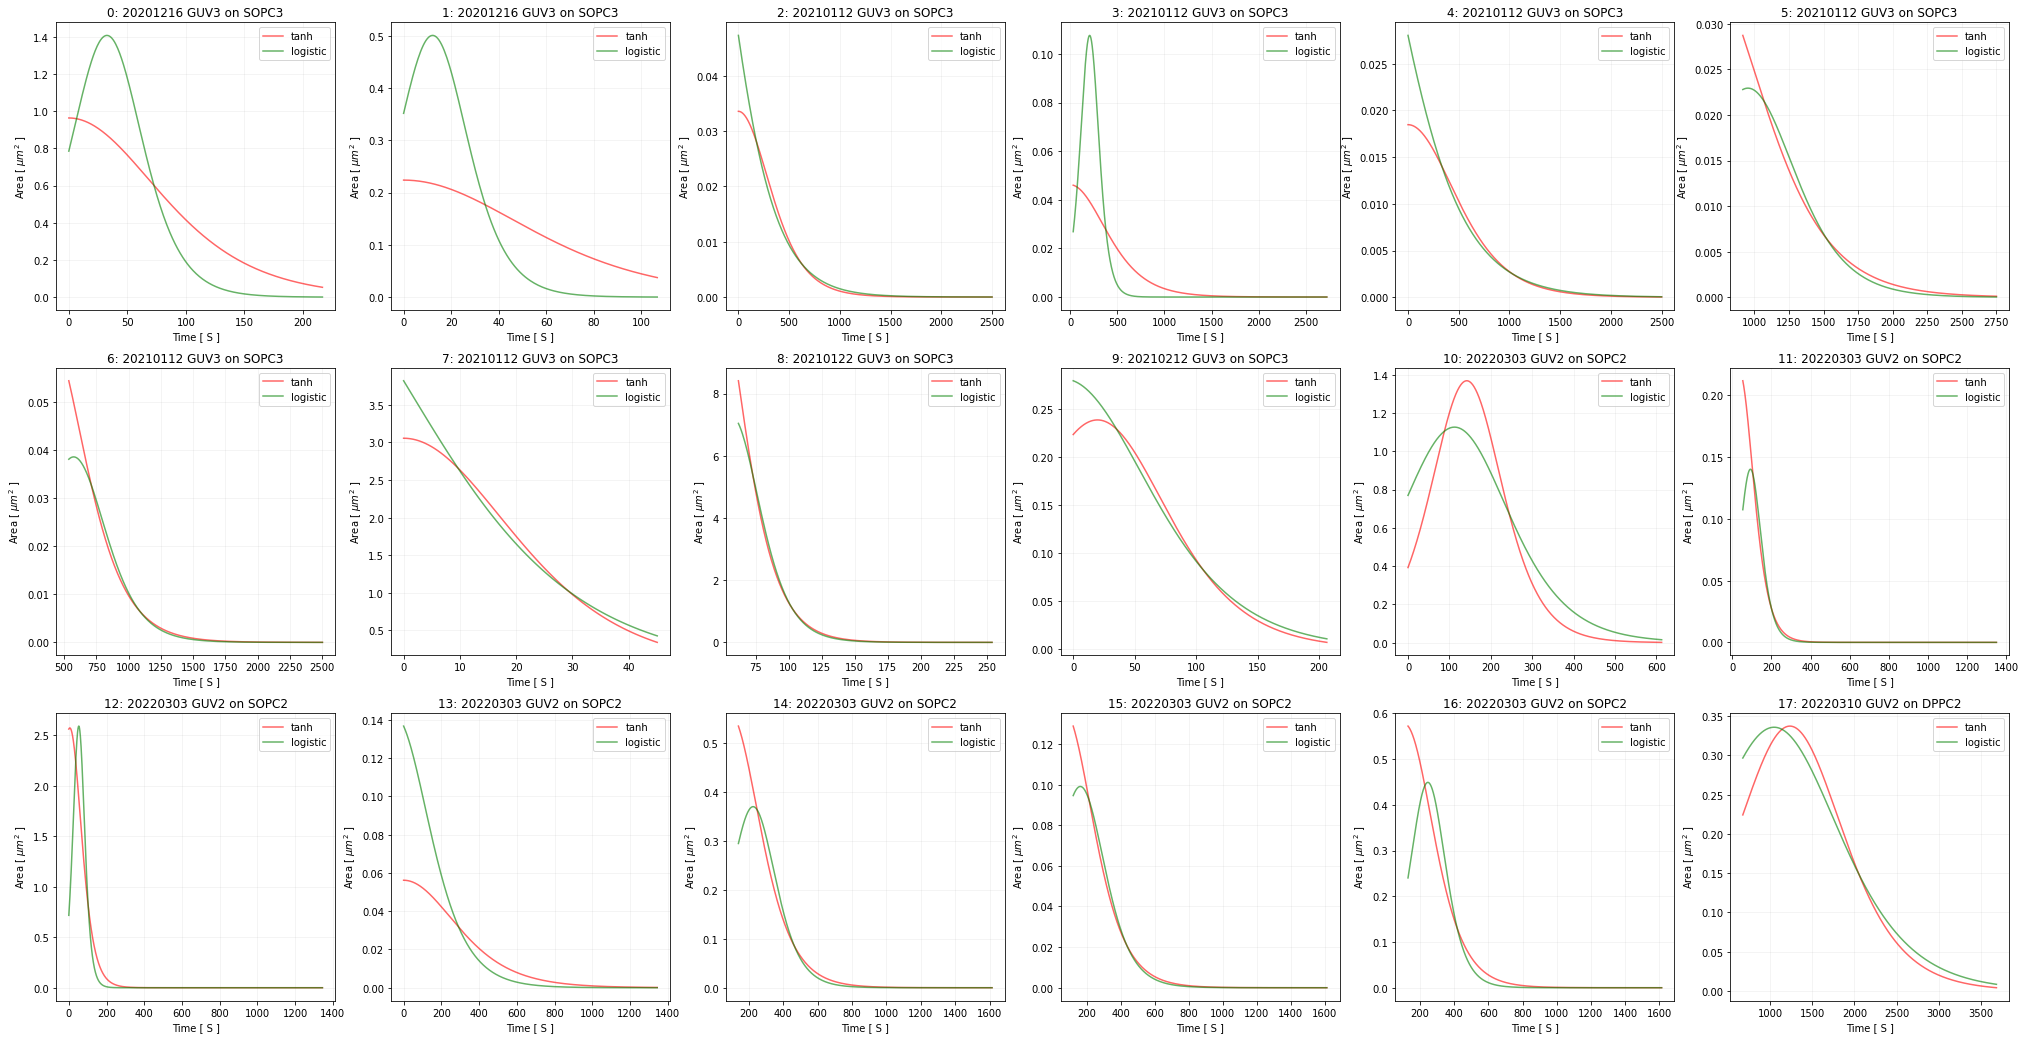

In [4]:
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

parameters_tanh, parameters_logistic = [], []
for i in range(18):
    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]
    
    # Create an array of weights
    l = t.shape[0]
    sigmas = np.ones(l) * (np.max(A)/100)
    
    sigmas[:l//5] = sigmas[:l//5] * 0.1
    sigmas[l-2*l//5:] = sigmas[l-2*l//5:] * 0.1
    sigmas[l//5:l-2*l//5] = sigmas[l//5:l-2*l//5] * 3
    
    # Fit a general tanh function to the curves 
    popt_tanh, _ = curve_fit(area_tanh, t, A, sigma=sigmas,
                             p0=(np.max(A)-np.min(A), 0.01, 0, 0),
                             bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], 1.5*np.max(A)]))
    parameters_tanh.append(popt_tanh)
                   
    # Fit a general tanh function to the curves 
    popt_logistic, _ = curve_fit(area_logistic, t, A, sigma=sigmas,
                                 p0=(1, 0.01, np.max(A)),
                                 bounds=([0.1, 0.00001, np.min(A)], [np.min(A), 1, 2*np.max(A)]))
    parameters_logistic.append(popt_logistic)
    
    # Define the figure size only once
    if i==0: plt.figure(figsize=(35, 18))
    
    plt.subplot(3, 6, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
    plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')

# Save and show the figure
plt.savefig('Results/area_curves_with_weights_2')
plt.show()


# Draw the derivative curves
for i in range(18):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.figure(figsize=(35, 18))
    
    plt.subplot(3, 6, i+1)
    plt.plot(t, der_area_tanh(t, *parameters_tanh[i][:-1]), label='tanh', alpha = 0.6, color= 'r')           # tanh
    plt.plot(t, der_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')    # logistic    
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_with_weights_2_der')
plt.show()

### Save the parameters to the data frame

In [5]:
# Save the initial data frame with proper name
df.to_pickle('Results/manipulated_area_curves_2.pkl')

# Add columns for the model to the data frame
df['Model_tanh'] = parameters_tanh
df['Model_logistic'] = parameters_logistic

# Save the results data frame as pickle
df.to_pickle('Results/result_area_curves_2.pkl')

# Save a csv and excel to be used out of python
df.drop(['Time', 'Area'], axis=1).to_csv('Results/result_area_curves_2.csv', index=False)
df.drop(['Time', 'Area'], axis=1).to_excel('Results/result_area_curves_2.xlsx', index=False)

df

,Date,Protein,Discription,Name,Time,Area,Model_tanh,Model_logistic
0,20201216,Mouse Ecad,GUV3 on SOPC3,Calib_camera1and2-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[19.203125, 19.15625, 19.484375, 20.359375, 20...","[98.0401782885993, 0.009826478866541229, 1.131...","[19.15624999999978, 0.04922244682326558, 114.3..."
1,20201216,Mouse Ecad,GUV3 on SOPC3,Calib_camera3-3,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[4.53125, 4.859375, 5.40625, 5.6875, 6.078125,...","[15.465193437567912, 0.014470600268596005, 3.1...","[4.531249999999998, 0.10035821985372294, 19.95..."
2,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[87.140625, 86.953125, 86.765625, 86.75, 86.93...","[13.918857788282974, 0.002411855164832463, 1.0...","[86.74999999999999, 0.003760215996090571, 101...."
3,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-2,"[33.0, 33.55, 34.1, 34.65, 35.2, 35.75, 36.3, ...","[1.1875, 1.28125, 1.25, 1.59375, 1.765625, 2.0...","[23.43019498044727, 0.0019720989729996507, 1.0...","[1.1874999999999998, 0.01512601094512014, 28.4..."
4,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-3,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[68.078125, 68.203125, 68.515625, 68.34375, 68...","[11.481296597078902, 0.0016088310736692842, 6....","[68.07812499999997, 0.0026508543331994912, 80...."
5,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-4,"[916.0, 917.0, 918.0, 919.0, 920.0, 921.0, 922...","[5.265625, 5.40625, 5.515625, 5.875, 6.0625, 6...","[22.562499999999996, 0.0016552619450146031, 59...","[0.3108901205999833, 0.004397262795303274, 20...."
6,20210112,Mouse Ecad,GUV3 on SOPC3,movie-200-550ms-1200-1sec_240_1200-1sec-5,"[537.0, 538.0, 539.0, 540.0, 541.0, 542.0, 543...","[4.265625, 4.859375, 5.3125, 5.96875, 6.203125...","[26.734374999999996, 0.0025001674748148356, 35...","[0.7851541534951113, 0.00601609231804769, 25.6..."
7,20210112,Mouse Ecad,GUV3 on SOPC3,movie-550ms-1,"[0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...","[283.78125, 285.921875, 287.90625, 290.109375,...","[78.33015035887423, 0.03901338299474238, 3.186...","[283.78124999999994, 0.05909803993479774, 367...."
8,20210122,Mouse Ecad,GUV3 on SOPC3,movie-1200-3sec-1,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...","[254.59375, 255.1875, 256.03125, 258.53125, 26...","[422.7499999999998, 0.030230400646743847, 39.8...","[7.840755339691889, 0.06969446709013317, 417.6..."
9,20210212,Mouse Ecad,GUV3 on SOPC3,movie-600_11_600_16_600-10ms-1,"[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6000000000000...","[28.1875, 28.0, 28.203125, 28.078125, 28.07812...","[18.24380410338134, 0.0130596306506092, 19.755...","[27.999999999999996, 0.021622611030211295, 51...."


### Print the fitted equations

In [6]:
for i, parameter in enumerate(parameters_tanh):
    print(i, ' --> {:.1f} tanh[{:.1e} (t - {:.1e})] + {:.1f}'.format(*parameter))

0  --> 98.0 tanh[9.8e-03 (t - 1.1e-32)] + 23.5
1  --> 15.5 tanh[1.4e-02 (t - 3.1e-30)] + 7.1
2  --> 13.9 tanh[2.4e-03 (t - 1.0e-09)] + 87.5
3  --> 23.4 tanh[2.0e-03 (t - 1.0e-15)] + 6.0
4  --> 11.5 tanh[1.6e-03 (t - 6.3e-13)] + 69.1
5  --> 22.6 tanh[1.7e-03 (t - 6.0e+02)] + -1.6
6  --> 26.7 tanh[2.5e-03 (t - 3.5e+02)] + -1.1
7  --> 78.3 tanh[3.9e-02 (t - 3.2e-14)] + 285.7
8  --> 422.7 tanh[3.0e-02 (t - 4.0e+01)] + -4.9
9  --> 18.2 tanh[1.3e-02 (t - 2.0e+01)] + 33.3
10  --> 157.1 tanh[8.7e-03 (t - 1.4e+02)] + 234.5
11  --> 21.2 tanh[1.0e-02 (t - 3.6e+01)] + -0.5
12  --> 211.9 tanh[1.2e-02 (t - 5.4e+00)] + 7.8
13  --> 20.6 tanh[2.7e-03 (t - 5.9e-11)] + 49.8
14  --> 133.7 tanh[4.2e-03 (t - 8.5e+01)] + -3.8
15  --> 32.3 tanh[4.3e-03 (t - 5.9e+01)] + 6.1
16  --> 128.5 tanh[4.5e-03 (t - 1.1e+02)] + -2.8
17  --> 285.7 tanh[1.2e-03 (t - 1.2e+03)] + 408.8


In [7]:
for i, parameter in enumerate(parameters_logistic):
    print(i, 'A0 = {:.1f}, r = {:.5f}, k = {:.1f}'.format(*parameter))

0 A0 = 19.2, r = 0.04922, k = 114.4
1 A0 = 4.5, r = 0.10036, k = 20.0
2 A0 = 86.7, r = 0.00376, k = 101.5
3 A0 = 1.2, r = 0.01513, k = 28.5
4 A0 = 68.1, r = 0.00265, k = 80.6
5 A0 = 0.3, r = 0.00440, k = 20.9
6 A0 = 0.8, r = 0.00602, k = 25.7
7 A0 = 283.8, r = 0.05910, k = 367.5
8 A0 = 7.8, r = 0.06969, k = 417.6
9 A0 = 28.0, r = 0.02162, k = 51.9
10 A0 = 86.8, r = 0.01134, k = 397.1
11 A0 = 1.5, r = 0.02711, k = 20.7
12 A0 = 16.3, r = 0.04756, k = 217.8
13 A0 = 42.0, r = 0.00812, k = 70.1
14 A0 = 9.3, r = 0.01139, k = 129.7
15 A0 = 6.2, r = 0.01033, k = 38.4
16 A0 = 3.6, r = 0.01434, k = 125.3
17 A0 = 83.6, r = 0.00192, k = 701.4


### Plot the growth rate vs carrying capacity

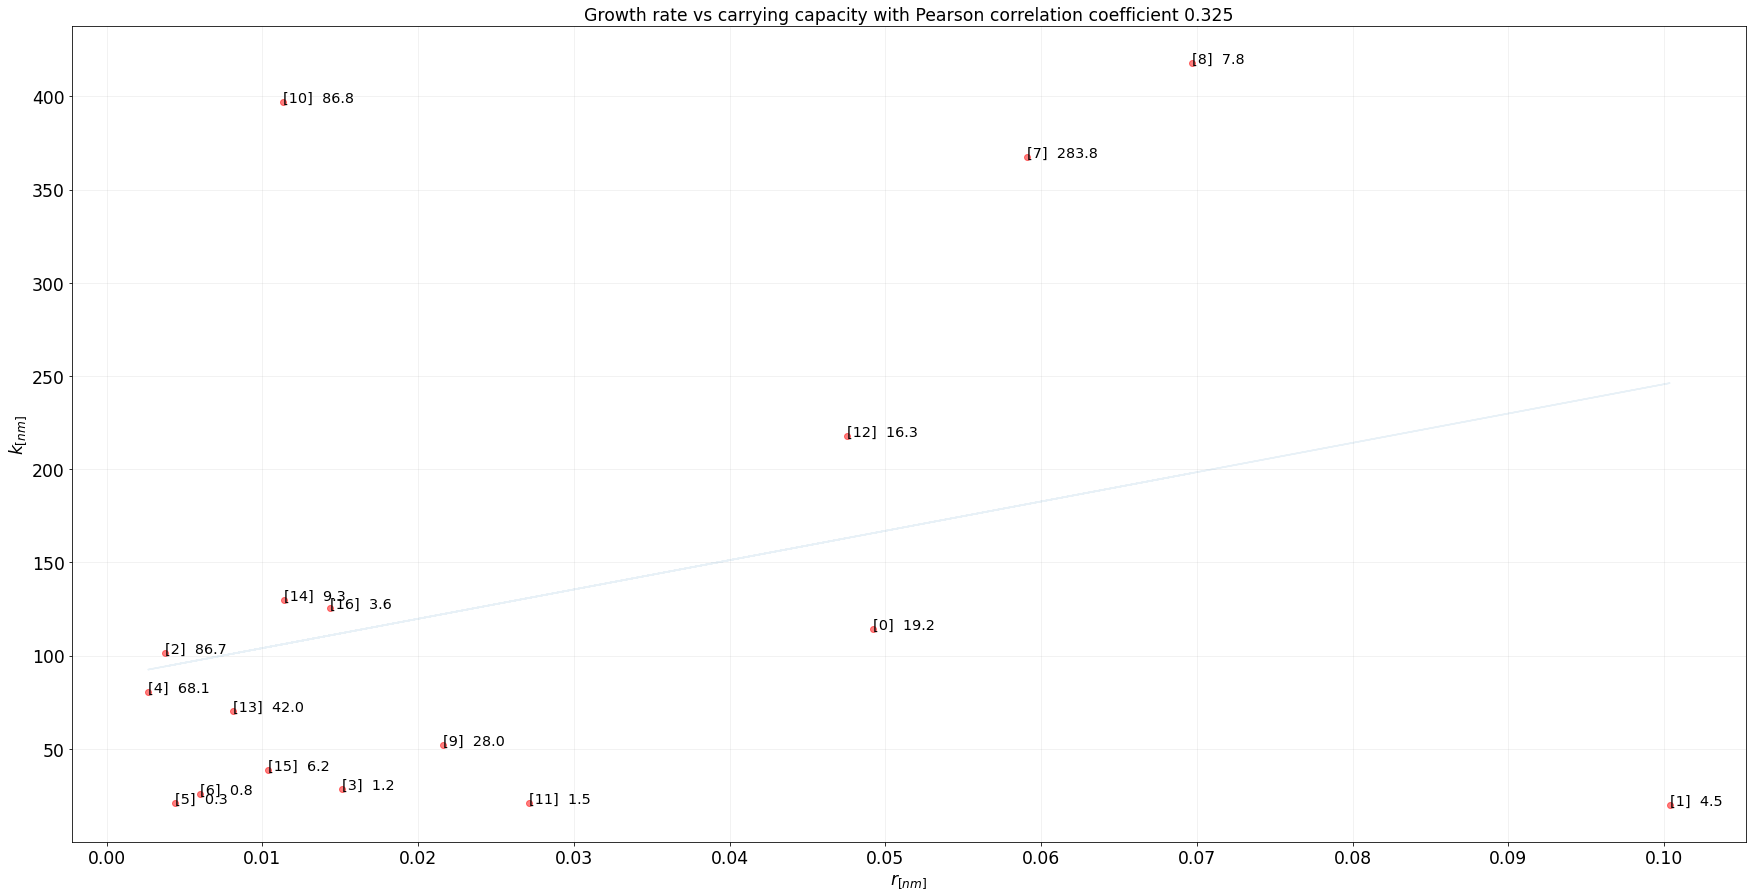

In [8]:
# Extract the logistic parameters excluding the DPPC curve
r = np.array([parameter[1] for parameter in df['Model_logistic'][:-1]])
k = np.array([parameter[2] for parameter in df['Model_logistic'][:-1]])
a = np.array([parameter[0] for parameter in df['Model_logistic'][:-1]])

# Calculate the slope and intercept of the growth rate and carrying capacity
m, b = np.polyfit(r, k, 1)

# Calculate the Pearson correlation coefficient
p = np.corrcoef(r, k)[0][1]

# Plot the results
plt.figure(figsize=(30,15))

# Scatter the growth rate against the carrying capacity
plt.scatter(r, k, color='red', alpha = 0.5)

# Annotate each data point with it's index and initial area
for i, A in enumerate(a): plt.annotate(f'[{i}]  {A:.1f}', (r[i], k[i]), fontsize='x-large')

# plot the fitted line between the data points
plt.plot(r, m*r + b, alpha=0.1)

plt.xlabel('$r_{[nm]}$', fontsize='xx-large')
plt.ylabel('$k_{[nm]}$', fontsize='xx-large')
plt.title(f'Growth rate vs carrying capacity with Pearson correlation coefficient {p:.3f}', fontsize='xx-large')
plt.xticks(np.arange(0,0.11,0.01), fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.savefig('Results/Growth_rate_vs_carrying_capacity')

### Plot a histogram for the growth rate and the carrying capacity

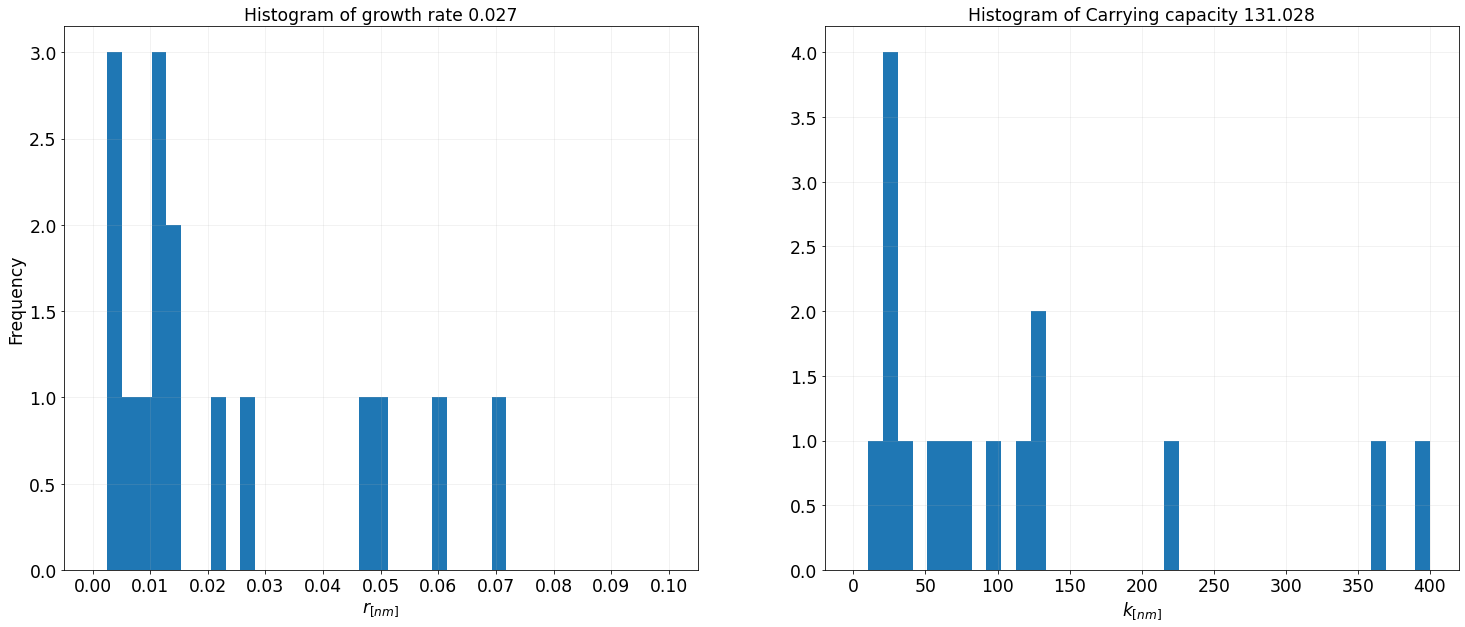

In [9]:
# Plot the results
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.hist(r, bins=np.linspace(0,0.1,40))
plt.xlabel('$r_{[nm]}$', fontsize='xx-large')
plt.ylabel('Frequency', fontsize='xx-large')
plt.title(f'Histogram of growth rate {r.mean():.3f}', fontsize='xx-large')
plt.xticks(np.arange(0,0.11,0.01), fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)

plt.subplot(1,2,2)
plt.hist(k, bins=np.linspace(0,400,40))
plt.xlabel('$k_{[nm]}$', fontsize='xx-large')
#plt.ylabel('Frequency', fontsize='xx-large')
plt.title(f'Histogram of Carrying capacity {k.mean():.3f}', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.savefig('Results/Growth_rate_and_carrying_capacity histograms')

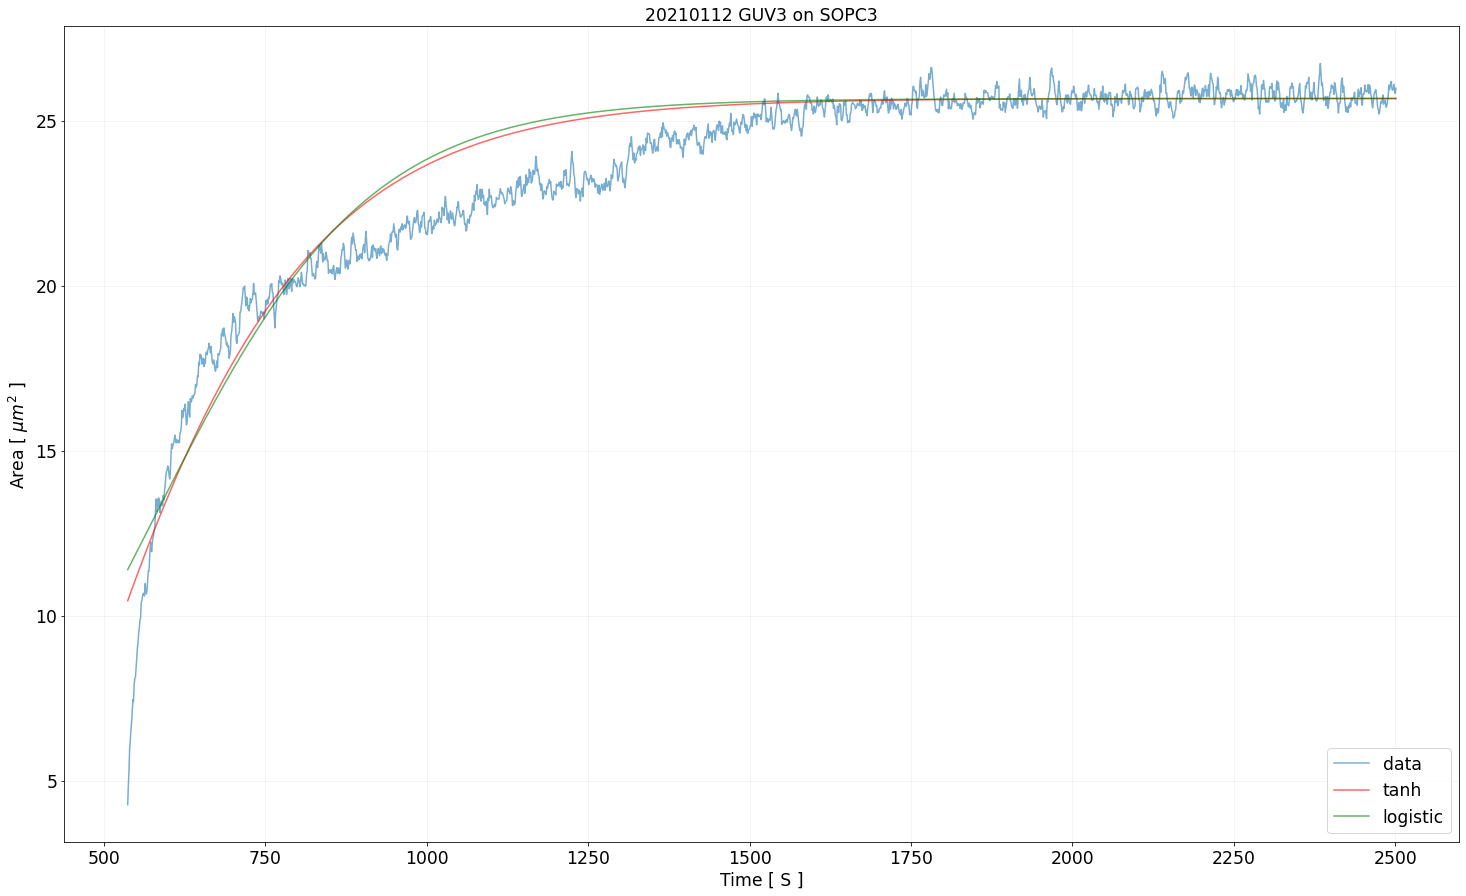

In [10]:
i = 6
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

# Read the time and area
t, A = df['Time'][i], df['Area'][i]

# Create an array of weights
l = t.shape[0]
sigmas = np.ones(l) * (np.max(A)/50)
sigmas[:l//5] = sigmas[:l//5] * 0.1
sigmas[l-2*l//5:] = sigmas[l-2*l//5:] * 0.1
sigmas[l//5:l-2*l//5] = sigmas[l//5:l-2*l//5] * 5

# Fit a general tanh function to the curves 
popt_tanh, _ = curve_fit(area_tanh, t, A, sigma=sigmas,
                         p0=(np.max(A)-np.min(A), 0.01, 0, 0),
                         bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], 1.5*np.max(A)]))

# Fit a general tanh function to the curves 
popt_logistic, _ = curve_fit(area_logistic, t, A, sigma=sigmas,
                             p0=(1, 0.01, np.max(A)),
                             bounds=([0.1, 0.00001, np.min(A)], [np.min(A), 1, 2*np.max(A)]))

# Define the figure size only once
plt.figure(figsize=(25, 15))
plt.plot(t, A, label='data', alpha = 0.6)                                                   # data
plt.plot(t, area_tanh(t, *popt_tanh), label='tanh', alpha = 0.6, color= 'r')                # tanh
plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')    # logistic    
plt.title(f'{df["Date"][i]} {df["Discription"][i]}', fontsize='xx-large')
plt.xlabel('Time [ S ]', fontsize='xx-large')
plt.ylabel('Area [ $\mu m^2$ ]', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(color = 'gray', alpha = 0.1)
plt.legend(loc='lower right', fontsize='xx-large')

#plt.savefig('area_curves_with_weights')